In [1]:
import os
import json
import pandas as pd
from datetime import datetime

DATA_DIR = 'data'

dynasty_rows = []
redraft_rows = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.json'):
        filepath = os.path.join(DATA_DIR, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            # Use 'lastUpdated' field for timestamp if available, else fallback to file mtime
            last_updated = data.get('lastUpdated')
            if last_updated:
                try:
                    # Remove 'Z' if present and parse as UTC
                    timestamp = datetime.fromisoformat(last_updated.replace('Z', '+00:00'))
                except Exception:
                    timestamp = datetime.fromtimestamp(os.path.getmtime(filepath))
            else:
                timestamp = datetime.fromtimestamp(os.path.getmtime(filepath))
            # Dynasty
            dynasty_row = {'timestamp': timestamp, 'filename': filename}
            if data.get('rankedByDynasty') and 'teams' in data['rankedByDynasty']:
                for team in data['rankedByDynasty']['teams']:
                    team_name = team.get('owner', '')
                    overall_value = team.get('overallValue', None)
                    if team_name:
                        dynasty_row[f'dynasty_team_{team_name}'] = overall_value
            dynasty_rows.append(dynasty_row)
            # Redraft
            redraft_row = {'timestamp': timestamp, 'filename': filename}
            if data.get('rankedByRedraft') and 'teams' in data['rankedByRedraft']:
                for team in data['rankedByRedraft']['teams']:
                    team_name = team.get('owner', '')
                    overall_value = team.get('overallValue', None)
                    if team_name:
                        redraft_row[f'redraft_team_{team_name}'] = overall_value
            redraft_rows.append(redraft_row)

# Create DataFrames
df_dynasty = pd.DataFrame(dynasty_rows).sort_values('timestamp').reset_index(drop=True)
df_redraft = pd.DataFrame(redraft_rows).sort_values('timestamp').reset_index(drop=True)

# Save to CSV (optional)
# df_dynasty.to_csv('dynasty_rankings_by_timestamp.csv', index=False)
# df_redraft.to_csv('redraft_rankings_by_timestamp.csv', index=False)

df_dynasty.tail()

,timestamp,filename,dynasty_team_mikulis,dynasty_team_dvdtequa,dynasty_team_mmasison,dynasty_team_dbrickashawc,dynasty_team_dlaffs,dynasty_team_benslayer68,dynasty_team_hunterm19,dynasty_team_schlaich,dynasty_team_izzyfromdwntwn,dynasty_team_pjwelling,dynasty_team_thinkfast86,dynasty_team_diddledum
76,2025-11-19 07:14:27.126167+00:00,fantasycalc_2025-11-20T07-14-05Z.json,78475,84962,76945,76775,72764,71276,67351,72687,67612,70654,69269,61524
77,2025-11-20 16:46:59.460687+00:00,fantasycalc_2025-11-21T07-14-16Z.json,78644,85212,75806,75391,71752,70666,66875,72719,66873,69559,68156,60841
78,2025-11-22 07:12:25.107000+00:00,fantasycalc_2025-11-22T07-12-25Z.json,79939,85232,76517,75850,71950,71024,66832,73009,67524,70518,68429,60928
79,2025-11-23 02:05:23.780292+00:00,fantasycalc_2025-11-23T07-12-55Z.json,79135,85160,76326,75951,72214,70962,66512,73034,67626,70474,68536,60826
80,2025-11-23 16:22:25.961195+00:00,fantasycalc_2025-11-24T07-14-40Z.json,79546,85526,77583,76674,72662,71665,66935,74203,67485,70717,68895,61692


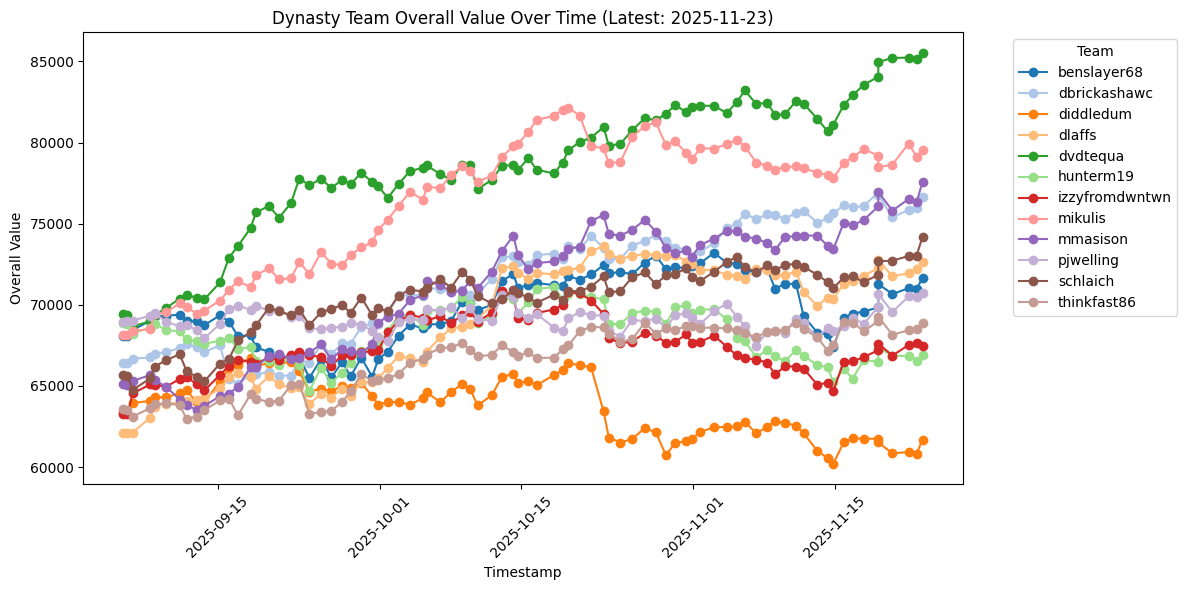

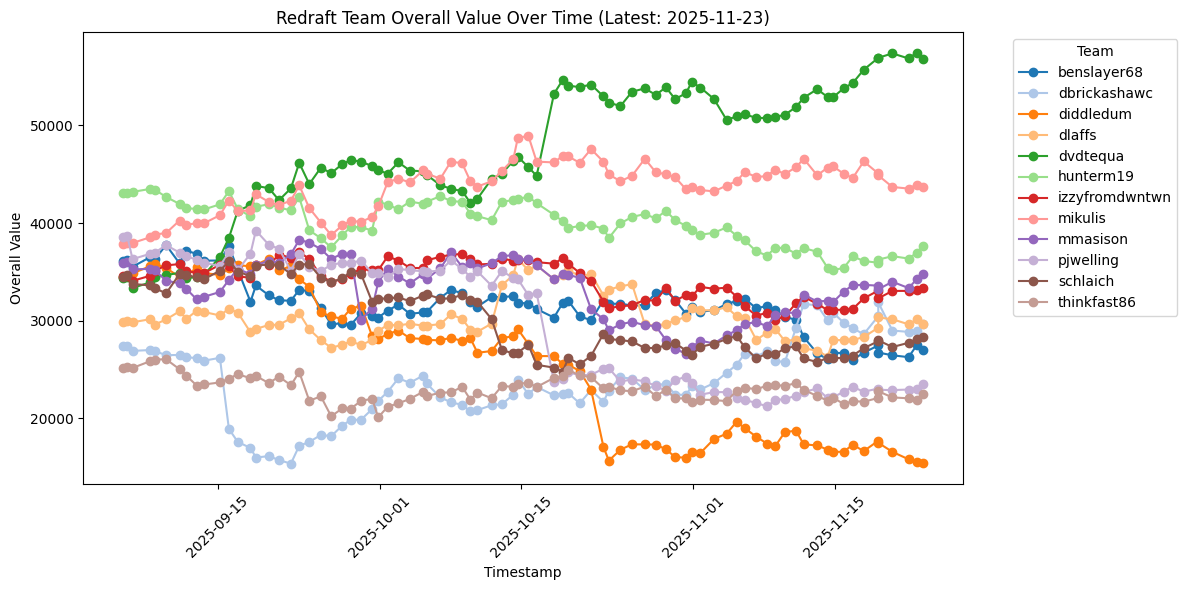

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Use the union of all team columns for consistent color mapping
all_team_names = set(
    [col.replace('dynasty_team_', '') for col in df_dynasty.columns if col.startswith('dynasty_team_')] +
    [col.replace('redraft_team_', '') for col in df_redraft.columns if col.startswith('redraft_team_')]
)
all_team_names = sorted(all_team_names)
color_map = {name: plt.get_cmap('tab20')(i % 20) for i, name in enumerate(all_team_names)}

# Dynasty plot with consistent colors and legend order
dynasty_team_cols = [f'dynasty_team_{name}' for name in all_team_names if f'dynasty_team_{name}' in df_dynasty.columns]
latest_dynasty_date = df_dynasty['timestamp'].max().date()

# Dynasty plot
plt.figure(figsize=(12, 6))
for col, name in zip(dynasty_team_cols, all_team_names):
    if col in df_dynasty.columns:
        plt.plot(df_dynasty['timestamp'], df_dynasty[col], marker='o', label=name, color=color_map[name])
plt.title(f'Dynasty Team Overall Value Over Time (Latest: {latest_dynasty_date})')
plt.xlabel('Timestamp')
plt.ylabel('Overall Value')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', labels=all_team_names)
plt.tight_layout()
plt.show()

redraft_team_cols = [f'redraft_team_{name}' for name in all_team_names if f'redraft_team_{name}' in df_redraft.columns]
latest_redraft_date = df_redraft['timestamp'].max().date()

# Redraft plot
plt.figure(figsize=(12, 6))
for col, name in zip(redraft_team_cols, all_team_names):
    if col in df_redraft.columns:
        plt.plot(df_redraft['timestamp'], df_redraft[col], marker='o', label=name, color=color_map[name])
plt.title(f'Redraft Team Overall Value Over Time (Latest: {latest_redraft_date})')
plt.xlabel('Timestamp')
plt.ylabel('Overall Value')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', labels=all_team_names)
plt.tight_layout()
plt.show()